# USING K MEANS ALGORITHM ON AN AUDIO DATASET

## K-MEANS CLUSTERING

### Introduction to K-means

K-means is a popular unsupervised machine learning algorithm used for clustering data. 
The main objective of K-means is to partition a dataset into K clusters such that each point is similar to points in its cluster and dissimilar to points in the other clusters.

The figure shown below represents k=3 clusters being made on a provided dataset.

<figure>
    <img src="k-means1.png",
        width=600,
        height=300,
         alt="Albuquerque, New Mexico">
    <figcaption></figcaption>
</figure>
Source: <a href="https://miro.medium.com/v2/resize:fit:1200/1*rw8IUza1dbffBhiA4i0GNQ.png">K-Means clustering</a> 

### The k-means clustering algorithm
The algorithm consists of the following steps
1. **Initialization:** Randomly take k initial clusters. The parameter k is given as input to the algorithm.
2. **Cluster Assignment:** For each point in the given dataset, assign it to the closest centroid.
3. **Centroid Update:** After all data points are assigned, recalculate the centroids for each cluster.
4. **Check for Convergence:** If the centroids have not changed compared to previous ones, the algorithm has converged and can be stopped else continue from step 2.

### Some of the areas where k-means clustering can be used are : 
* **Customer Segmentation:** Identify groups of customers with similar behaviors and needs to personalize interactions and improve customer satisfaction.
* **Image Compression:** Reducing the number of colors in an image by clustering similar pixels.
* **Anomaly Detection:** Identifying outliers or unusual patterns in data.
* **Document Clustering:** Organizing documents into topics or categories based on their content

### Advantages of using k-means algorithm
* The algorithm is easy to implement and the time complexity scales linearly with n.
* Generally euclidean distance is used but various distance measures can be used for clustering making it flexible for different scenarios.
* The algorithm gaurantees convergence.

### Limitations of k-means algorithm
* Requires specifying the number of clusters beforehand, which can be challenging.
* Sensitive to the initial placement of centroids.
* Assumes spherical clusters, which may not always be the case.

### Some interesting facts about the K-Means algorithm
* **NP-Hard Problem**: Finding the optimal solution for K-Means clustering is actually an NP-hard problem. This means that as the number of data points or clusters increases, finding the absolute best solution becomes computationally infeasible. However, K-Means is efficient at finding good local optima, which are often sufficient for practical applications.
* **Curse of Dimensionality:** As the number of dimensions (features) in your data increases, the performance of K-Means tends to degrade. This is because the concept of distance becomes less meaningful in high-dimensional spaces.
* **Various Modifications:** Different modifications can be applied to the algorithm to make it suitable for different scenarios. Some of the examples include online K-Means, bisecting K-Means and Mini-Batch K-Means.

## Audio MFCCs: Mel-Frequency Cepstral Coefficients

* The mel-frequency cepstrum is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.
* Mel-frequency cepstral coefficients are coefficients that collectively make up an MFC.
* **They are a way of describing the characteristics of sound similar to how people perceive it**.

### MFCC is calculated as follows:

* **Limiting the signal:** The audio signal is divided into short frames, usually about 20-40 milliseconds long. 
* **Fast Fourier Transform (FFT):** Each frame is then converted **from the time domain to the frequency** domain using an FFT.
This provides information about the different frequencies of the sound.
* **Mel frequency envelope:** The frequency spectrum is then mapped to the mel scale, which is a perceptual scale of pitches that listeners perceive as equal to each other. This scale is closer to human hearing than a linear frequency scale.
* **Log Energies: The** energy of each mel-frequency band is calculated and then converted to a logarithmic scale.
* **Discrete Cosine Transform (DCT):** Finally, the log-mel spectrum is transformed **back to the time domain** using a Discrete Cosine Transform (DCT). The resulting coefficients are MFCCs.

### Why are MFCCs useful?
* **Compact representation:** MFCCs provide a compact representation of audio, capturing important features and discarding less important information.
* **Noise Immunity:** They are relatively immune to noise and audio signal fluctuations.
* **Speaker and speech recognition:** MFCCs are widely used in speaker recognition and speech recognition systems due to their ability to capture important features of speech sounds.
* **Music Data Search:** This can be used for things like music genre classification, artist identification, and mood detection.

### Limitations of MFCCs:
* **Data loss:** Although MFCCs store important functions, they lose some audio.
* **Limited temporal resolution:** Due to the framing process, MFCCs have limited temporal resolution and may not capture rapid changes in sound.

### Some Points to Note:
* The mel scale used in MFCC calculation is **Inspired by Human Hearing**.
* For incorporating information about the temporal changes in sound, the **first and second derivatives of the MFCCs** are often calculated. These represent and provide additional features related to the rate of change in the spectral envelope.


## DEMONSTRATION THROUGH PRACTICAL DATASET

I have used the free spoken digit dataset and tried to analyse how k-means clusters the different recordings available in the dataset.
A simple audio/speech dataset consisting of recordings of spoken digits in wav files at 8kHz. The recordings are trimmed so that they have near minimal silence at the beginnings and ends.

The current status of the dataset is:
* 6 speakers
* 3,000 recordings (50 of each digit per speaker)
* English pronunciations

Source of the dataset :  <a href="https://github.com/Jakobovski/free-spoken-digit-dataset">FSDD dataset!</a> 

In [54]:
# Importing necessary libraries
import librosa
import os
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import kurtosis, skew, mode
from sklearn import metrics

In [10]:
# function cal_stat takes a audio feature as argument and return its statistic measures:
# minimum, maximum, mean, standard deviation, skewness and kurtosis

# Skewness measures the asymmetry of a distribution. 
# Kurtosis indicates how heavily the data is concentrated around the mean.
def cal_stat(feature):
    min_val = np.min(feature,axis=1)
    max_val = np.max(feature,axis=1)
    mean_val = feature.mean(axis=1)
    std_val = feature.std(axis=1)
    skewness_val = skew(feature.T,bias = False)
    kurtosis_val = kurtosis(feature.T,fisher=False,bias=False)
    stat_val = np.hstack([min_val,max_val,mean_val,std_val,skewness_val,kurtosis_val])
    return stat_val

In [11]:
def get_mfccs(data_dir=None):
    mfcc_info, labels = [], []

    if data_dir is None:
        data_dir = os.path.dirname(__file__) + '/../mfcss'
        print(data_dir)

    file_paths = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f)) and '.wav' in f]

    if len(file_paths) == 0:
        raise Exception('There are no files in the spectrogram directory. Make sure to run the spectrogram.py before calling this function.')

    for file_name in file_paths:
        label = int(file_name[0])
        labels.append(label)
        audio_path = data_dir + '/' + file_name
        audio, sr = librosa.load(audio_path, sr=None)
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, n_fft=1024)
        delta_mfccs = librosa.feature.delta(mfccs, width=3) # first derivatives
        delta2_mfccs = librosa.feature.delta(mfccs, order=2, width=3) # second derivatives
        
        mfcc_stat = cal_stat(mfccs)
        d1mfcc_stat = cal_stat(delta_mfccs)
        d2mfcc_stat = cal_stat(delta2_mfccs)
        all_mfcc_stat = np.hstack([mfcc_stat,d1mfcc_stat,d2mfcc_stat])
        
        mfcc_info.append(all_mfcc_stat)

    return mfcc_info, labels

In [16]:
# loding all recordings and recordings specific to a particular speaker george
audio_dir = "./recordings/"
mfcc_info, labels = get_mfccs(audio_dir)
george_dir = "./george_recs/"
mfcc_info_george, labels_george = get_mfccs(george_dir)

C:\Users\91971\AppData\Local\Temp\ipykernel_23420\1208522959.py:11: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness_val = skew(feature.T,bias = False)
C:\Users\91971\AppData\Local\Temp\ipykernel_23420\1208522959.py:12: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis_val = kurtosis(feature.T,fisher=False,bias=False)


In [17]:
audio_labels = np.asarray(labels)
mfccs = np.array(mfcc_info)

audio_labels_george = np.asarray(labels_george)
mfccs_george = np.array(mfcc_info_george)

print("audio labels shape is: ", audio_labels.shape)
print("Total global features (MFCC and its derivatives) are: ", mfccs.shape)

print("audio labels of george' recording: shape is: ", audio_labels_george.shape)
print("Total global features for george' recording: (MFCC and its derivatives) are: ", mfccs_george.shape)

audio labels shape is:  (3000,)
Total global features (MFCC and its derivatives) are:  (3000, 234)
audio labels of george' recording: shape is:  (500,)
Total global features for george' recording: (MFCC and its derivatives) are:  (500, 234)


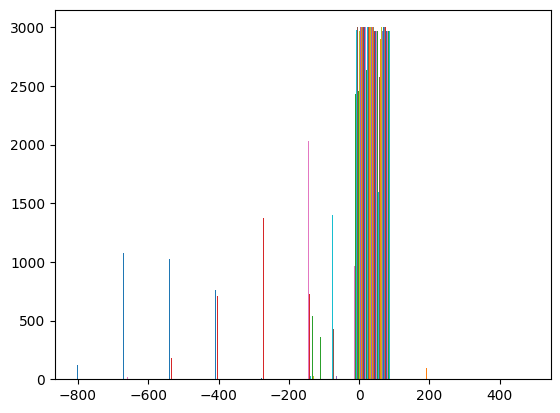

In [18]:
%matplotlib inline
plt.hist(mfccs);

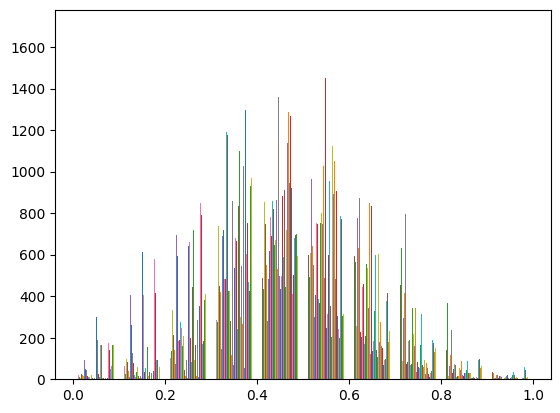

In [19]:
# scale mfccs using minmax 
mfccs_minmax = MinMaxScaler().fit_transform(mfccs)

%matplotlib inline
plt.hist(mfccs_minmax);

In [20]:
print(f"{np.count_nonzero(np.isnan(mfccs_minmax))}")
# replace not available values with zero
mfccs_minmax[np.isnan(mfccs_minmax)] = 0

1508


In [21]:
mfccs_minmax.shape

(3000, 234)

In [61]:
# Apply kmeans with 10 clusters
kmeans = KMeans(n_clusters=10,max_iter=1000)
kmeans.fit(mfccs_minmax)
cluster_labels = kmeans.labels_

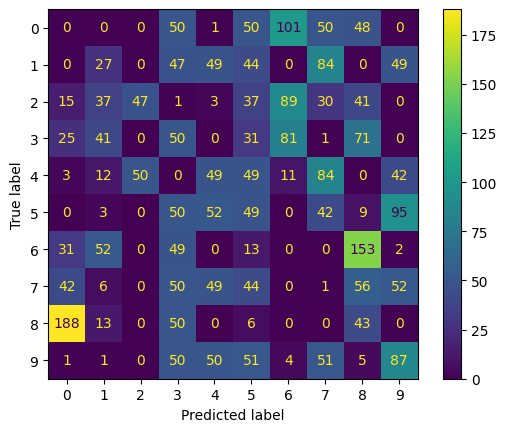

In [62]:
confusion_matrix = metrics.confusion_matrix(audio_labels, cluster_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [i for i in range(10)])

cm_display.plot()
plt.show()

* It is clear from the above confusion matrix that the 10 clusters formed are not such that each cluster has major occurrences of a single digit. So lets analyze how are the clusters made

In [63]:
# speakers change after every 50 recordings
for i in range(60):
    m = mode(cluster_labels[50*i:50*(i+1)])
    print(f"speaker {i%6}: {m}")

speaker 0: ModeResult(mode=3, count=50)
speaker 1: ModeResult(mode=6, count=50)
speaker 2: ModeResult(mode=8, count=48)
speaker 3: ModeResult(mode=5, count=50)
speaker 4: ModeResult(mode=6, count=50)
speaker 5: ModeResult(mode=7, count=50)
speaker 0: ModeResult(mode=3, count=47)
speaker 1: ModeResult(mode=9, count=46)
speaker 2: ModeResult(mode=4, count=48)
speaker 3: ModeResult(mode=5, count=44)
speaker 4: ModeResult(mode=7, count=31)
speaker 5: ModeResult(mode=7, count=48)
speaker 0: ModeResult(mode=2, count=47)
speaker 1: ModeResult(mode=6, count=50)
speaker 2: ModeResult(mode=8, count=38)
speaker 3: ModeResult(mode=5, count=36)
speaker 4: ModeResult(mode=6, count=29)
speaker 5: ModeResult(mode=7, count=30)
speaker 0: ModeResult(mode=3, count=48)
speaker 1: ModeResult(mode=6, count=48)
speaker 2: ModeResult(mode=8, count=50)
speaker 3: ModeResult(mode=5, count=31)
speaker 4: ModeResult(mode=6, count=33)
speaker 5: ModeResult(mode=0, count=23)
speaker 0: ModeResult(mode=2, count=50)


* In the above output we can observe that the speakers are getting allocated same clusters in make cases regardless of the digit spoken.
* It might be possible that according to the considered features, it is more natural to get clusters based on speaker identity than on the digit spoken.
* Let's see if we can get nice clusters based on speaker identity

In [64]:
speaker_labels = []
for digit in range(10):
    for speaker in range(6):
        speaker_labels+=[speaker]*50

In [65]:
np.array(speaker_labels).shape

(3000,)

In [114]:
# k means with 6 clusters
kmeans_6c = KMeans(n_clusters=6,max_iter=1000,random_state=31)
kmeans_6c.fit(mfccs_minmax)
cluster_labels_6c = kmeans_6c.labels_

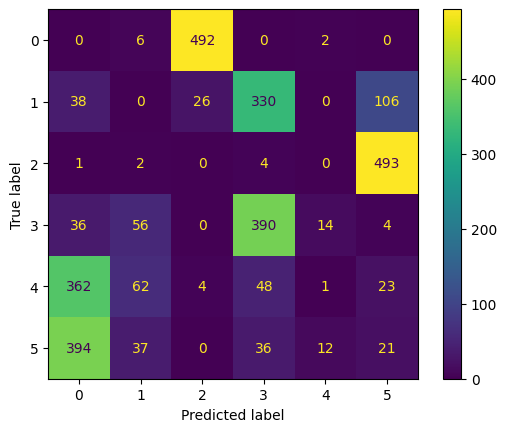

In [115]:
confusion_matrix_6c = metrics.confusion_matrix(speaker_labels, cluster_labels_6c)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_6c, display_labels = [i for i in range(6)])

cm_display.plot()
plt.show()

According to this confustion matrix, we can say that speakers are getting separated in a better way than digits keeping aside that there is still confusion between speaker 4 and 5.

### Let's discard delta terms from the dataset and see what happens

In [109]:
# k means with 6 clusters
kmeans_6c = KMeans(n_clusters=6,max_iter=1000,random_state=31)
kmeans_6c.fit(mfccs_minmax[:,:78+1])
cluster_labels_6c = kmeans_6c.labels_

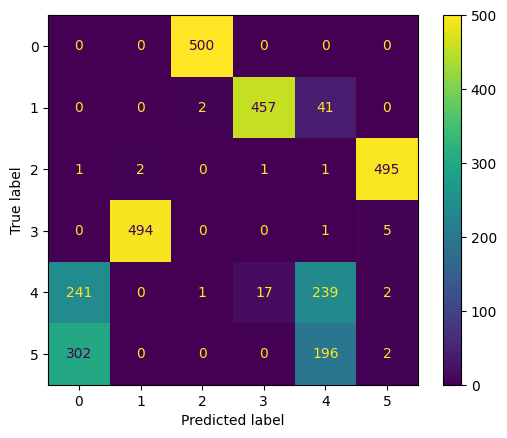

In [110]:
confusion_matrix_6c = metrics.confusion_matrix(speaker_labels, cluster_labels_6c)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_6c, display_labels = [i for i in range(6)])

cm_display.plot()
plt.show()


The confusion matrix is better in this case in terms of separating speaker. We can say that it is better to discard derivatives for speaker differentiation.

### Let's see what if we use recordings from only one speaker. Are clusters formed based on digits

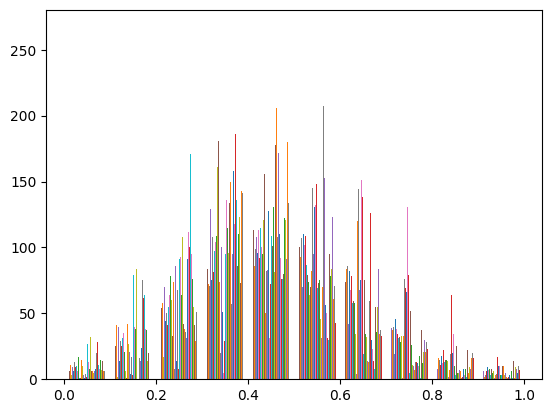

In [119]:
# scale mfccs using minmax 
mfccs_minmax_george = MinMaxScaler().fit_transform(mfccs_george)

%matplotlib inline
plt.hist(mfccs_minmax_george);

In [120]:
print(f"{np.count_nonzero(np.isnan(mfccs_minmax_george))}")
# replace not available values with zero
mfccs_minmax_george[np.isnan(mfccs_minmax_george)] = 0

104


In [125]:
# using all features
kmeans_george = KMeans(n_clusters=10,max_iter=1000,random_state=31)
kmeans_george.fit(mfccs_minmax_george)
cluster_labels_george = kmeans_george.labels_

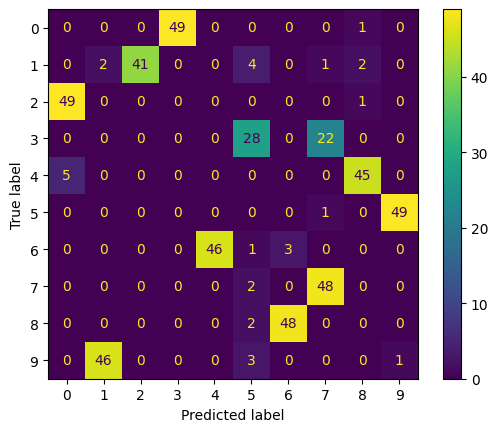

In [126]:
confusion_matrix_george = metrics.confusion_matrix(audio_labels_george, cluster_labels_george)
cm_display_george = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_george, display_labels = [i for i in range(10)])

cm_display_george.plot()
plt.show() 

The clusters are better than in case of multiple speakers!

### What if we discard derivatives of mfccs from features

In [134]:
kmeans_george = KMeans(n_clusters=10,max_iter=1000,random_state=31)
kmeans_george.fit(mfccs_minmax_george[:,:79])
cluster_labels_george = kmeans_george.labels_

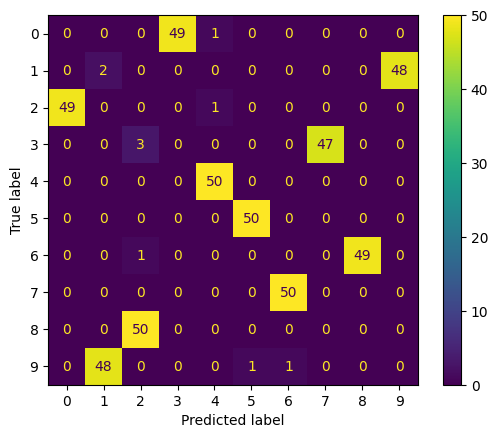

In [135]:
confusion_matrix_george = metrics.confusion_matrix(audio_labels_george, cluster_labels_george)
cm_display_george = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_george, display_labels = [i for i in range(10)])

cm_display_george.plot()
plt.show() 

In [139]:
# Rename clusters for better analysis
mapping = {
    0: 2,
    1: 9,
    2: 8,
    3: 0,
    4: 4,
    5: 5,
    6: 7,
    7: 3,
    8: 6,
    9: 1,
}

In [140]:
new_labels_george = [mapping[i] for i in cluster_labels_george]

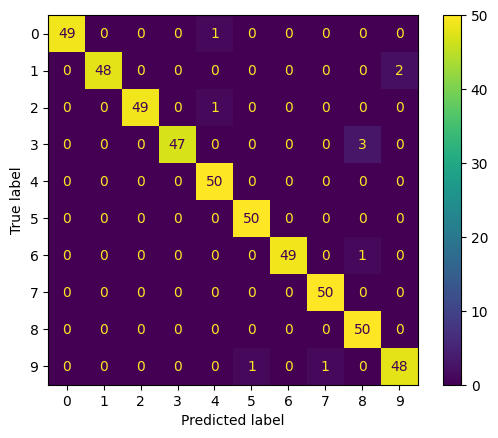

In [141]:
confusion_matrix_george = metrics.confusion_matrix(audio_labels_george, new_labels_george)
cm_display_george = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_george, display_labels = [i for i in range(10)])

cm_display_george.plot()
plt.show() 

**Clustering purely based on digits is achieved. Seems like using only mfccs works better in this scenario!!**

### Conclusions

* We saw how K-Means clustering works and observed its application on a real world audio dataset.
* K-Means is generally intended to be used for unsupervised learning but for the sake of observability we chose a labelled dataset and analyzed how K-Means was able make clusters out of the data.
* We found that the mfccs along with their first and second order derivates is not a good choice if we intend to make clusters based on spoken digits in the whole dataset but for a particular used, K-Means can do a great job.
* However, K-Means can cluster the data based on who the speaker is in case of dataset involving multiple speakers.